In [ ]:
### IMPORTS
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [ ]:
### FUNCTIONS
def winsorize(data,p):              ###INCOMPLETE XXXX
    p = p*0.01
    data_winsorized = np.copy(data)
    data_winsorized[data_winsorized < np.percentile(data, p*100)] = np.percentile(data, p*100)
    data_winsorized[data_winsorized > np.percentile(data, 100-p*100)] = np.percentile(data, 100-p*100)
    return 0

def partition_by_criteria(data,criteria):
    criteria_groups = data.groupby(criteria)   # Group the dataframe by subject_id

    # Create a dictionary of dataframes, one for each value in the criteria column
    partitions = {criteria: criteria_groups.get_group(criteria) for criteria in criteria_groups.groups}
    
    # Return the dictionary of partitions
    return partitions



In [ ]:
#INSTANCIATIONS & READING DATA & PREPROCESSING


# scaler = StandardScaler()

## reading test data
subject_id_test = pd.read_csv('Test/subject_id_test.txt')               #test subject
subject_id_test.columns = (['subject_id'])

test_data = pd.read_csv('Test/X_test.txt',delimiter=' ')                #test data

# test_data = pd.DataFrame(scaler.fit_transform(test_data))               #standardise data

test_data.columns = (['feature_' + str(i) for i in range(1, 562)])      #column names

test_labels = pd.read_csv('Test/y_test.txt')                            #test labels
test_labels.columns = (['labels'])

## reading training data
subject_id_train = pd.read_csv('Train/subject_id_train.txt')            #training subject
subject_id_train.columns = (['subject_id'])

train_data = pd.read_csv('Train/X_train.txt',delimiter=' ')             #training data

# train_data = pd.DataFrame(scaler.fit_transform(train_data))             #standardise data

train_data.columns = (['feature_' + str(i) for i in range(1, 562)])     #column names

train_labels = pd.read_csv('Train/y_train.txt')                         #training labels
train_labels.columns = (['labels'])


train_data.head(10)

entire_data = pd.concat([subject_id_train,train_data,test_labels], axis=1)
entire_data

# train_data.describe()

In [ ]:
## DATA MANIPULATIONS


## APPLY PCA with 3 features
pca = PCA(n_components=3)
train_data_pca = pd.DataFrame(pca.fit_transform(train_data))
train_data_pca.columns = ['pca_feature_' + str(x) for x in range(3)]


components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

print(train_data_pca)
# print(components)
# print(explained_variance_ratio)

In [ ]:
### RANDOM STUFF


# PLOT 1 - HAPT dataset - PCA (2d)

plot = plt.scatter(train_data_pca['pca_feature_0'],
           train_data_pca['pca_feature_1'],
           c=train_labels['labels'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('HAPT dataset - PCA (2d with 2 features)')




# PLOT 2 - HAPT dataset - PCA (3d scatter)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(train_data_pca['pca_feature_0'],
           train_data_pca['pca_feature_1'],
           train_data_pca['pca_feature_2'],
           c=train_labels['labels'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('HAPT dataset - PCA (3d scatter)')
plt.show()



# svm train
# svm = LinearSVC()
# svm.fit(train_data_pca,train_labels)

# print(classification_report(svm.predict(pd.DataFrame(pca.transform(test_data))),test_labels))

In [ ]:

### AGGREGATE DATA BY TEST SUBJECT AVERAGES ON A PARTICULAR LABEL ACTION

entire_data_pca = pd.concat([subject_id_train,train_data_pca,test_labels], axis=1)
entire_data_pca


entire_data_clean = pd.concat([subject_id_train,train_data,test_labels], axis=1).dropna()               ### remove rows with missing values
entire_data_pca_clean = pd.concat([subject_id_train,train_data_pca,test_labels], axis=1).dropna()
entire_data_pca_clean

labels_clean_partition = partition_by_criteria(entire_data_pca_clean,'labels')                                                   ### partition the data by labels



# get averages of test subjects on each activity label

def get_partition_avg_by_label(partition):                                                              ### this function returns the average of each pca feature in a partition grouped by labels
    pca1_avg = np.average(partition['pca_feature_0'])                                                   ### essentially a row. to be used where each row represents one label
    pca2_avg = np.average(partition['pca_feature_1'])
    pca3_avg = np.average(partition['pca_feature_2'])
    return pca1_avg, pca2_avg, pca3_avg


labels_clean_averages = []                                                                              ### list which will contain new values (average movement of all users for each movement type/label) to be plotted

for partition in labels_clean_partition.values():                                                       ### adding each row to the list for each label average
    partition = partition.reset_index()                                                                 ### due to the way dataframes work, the index of the partition has to be reset or else it maintains the original index of the 'labels_clean_partition'
    p1,p2,p3 = get_partition_avg_by_label(partition)
    label = partition['labels'][0]                                                                      ### 0 is an arbitrary value but a guaranteed value. every label here has the same value for 'label'
    labels_clean_averages.append([p1,p2,p3,label])

labels_clean_averages = pd.DataFrame(labels_clean_averages)                                             ### convert the list to a dataframe
labels_clean_averages.columns = (['pca_feature_0', 'pca_feature_1', 'pca_feature_2', 'labels'])          ### column names

print(labels_clean_averages)                                                                            ### checking output

In [ ]:
#### PLOTTING THE AVERAGES 


# PLOT 3 - HAPT dataset averages - PCA (2d)

plot = plt.scatter(labels_clean_averages['pca_feature_0'],
           labels_clean_averages['pca_feature_1'],
           c=labels_clean_averages['labels'])
plt.xlabel('PC1 Average for Label')
plt.ylabel('PC2 Average for Label')
plt.title('HAPT dataset averages- PCA (2d with 2 features)')




# PLOT 4 - HAPT dataset - PCA (3d scatter)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(labels_clean_averages['pca_feature_0'],
           labels_clean_averages['pca_feature_1'],
           labels_clean_averages['pca_feature_2'],
           c=labels_clean_averages['labels'])
ax.set_xlabel('PC1 Average for Label')
ax.set_ylabel('PC2 Average for Label')
ax.set_zlabel('PC3 Average for Label')
ax.set_title('HAPT dataset averages - PCA (3d scatter)')
plt.show()

In [ ]:
### AGGREGATE DATA BY LABELS AVERAGES ON A PARTICULAR TEST SUBJECT

subjects_clean_partition = partition_by_criteria(entire_data_pca_clean,'subject_id')                                                   ### partition the data by labels



# get averages of every label on each test subject

def get_partition_avg_by_subject_id(partition):                                                             ### this function returns the average of each pca feature in a partition grouped by labels
    pca1_avg = np.average(partition['pca_feature_0'])                                                       ### essentially a row. to be used where each row represents one label
    pca2_avg = np.average(partition['pca_feature_1'])
    pca3_avg = np.average(partition['pca_feature_2'])
    return pca1_avg, pca2_avg, pca3_avg


subjects_clean_averages = []                                                                                ### list which will contain new values (average movement of all users for each movement type/label) to be plotted

for partition in subjects_clean_partition.values():                                                           ### adding each row to the list for each label average
    partition = partition.reset_index()                                                                     ### due to the way dataframes work, the index of the partition has to be reset or else it maintains the original index of the 'labels_clean_partition'
    p1,p2,p3 = get_partition_avg_by_subject_id(partition)
    label = partition['subject_id'][0]                                                                      ### 0 is an arbitrary value but a guaranteed value. every label here has the same value for 'label'
    subjects_clean_averages.append([label,p1,p2,p3])

subjects_clean_averages = pd.DataFrame(subjects_clean_averages)                                               ### convert the list to a dataframe
subjects_clean_averages.columns = (['subject_id', 'pca_feature_0', 'pca_feature_1', 'pca_feature_2'])       ### column names

print(subjects_clean_averages)                                                                                ### checking output

In [ ]:
#### PLOTTING THE AVERAGES 


# PLOT 5 - HAPT dataset averages - PCA (2d)

plot = plt.scatter(subjects_clean_averages['pca_feature_0'],
           subjects_clean_averages['pca_feature_1'],
           c=subjects_clean_averages['subject_id'])
plt.xlabel('PC1 Average for Label')
plt.ylabel('PC2 Average for Label')
plt.title('HAPT dataset averages- PCA (2d with 2 features)')




# PLOT 6 - HAPT dataset - PCA (3d scatter)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(subjects_clean_averages['pca_feature_0'],
           subjects_clean_averages['pca_feature_1'],
           subjects_clean_averages['pca_feature_2'],
           c=subjects_clean_averages['subject_id'])
ax.set_xlabel('PC1 Average for Label')
ax.set_ylabel('PC2 Average for Label')
ax.set_zlabel('PC3 Average for Label')
ax.set_title('HAPT dataset averages - PCA (3d scatter)')
plt.show()

In [121]:
#### CONSIDERING THIS IS A TIME SERIES, WE WILL ATTEMPT TO PLOT A LINE CHART HERE USING A SINGLE PCA COMPONENT.
#### this plot will have a line indicating each label action (the 'labels_averages') and the x-axis will be
#### time (where each 50 records is a second)


### get all readings of each label in partitions

entire_labels_partition = partition_by_criteria(entire_data_pca,'labels')                                                   ### partition the data by labels



# get averages of every label on each test subject

entire_labels_partition_time = []                                                                                ### list which will contain new values (the partition of all records by labels) to be plotted

for partition in entire_labels_partition.values():                                                           ### adding each row to the list for each label average
    partition = partition.reset_index()                                                                     ### due to the way dataframes work, the index of the partition has to be reset or else it maintains the original index of the 'labels_clean_partition'
    partition = partition.drop(['index'], axis=1)
    partition['time'] = range(0,len(partition)*20,20) 
    label = partition['labels'][0]                                                                      ### 0 is an arbitrary value but a guaranteed value. every label here has the same value for 'label'
    entire_labels_partition_time.append(partition)

                                             ### column names

entire_labels_partition_time                                                                                ### checking output



[     subject_id  pca_feature_0  pca_feature_1  pca_feature_2  labels  time
 0             1       6.452987      -1.179131      -0.380964     1.0     0
 1             1       6.685712      -1.952410      -0.101967     1.0    20
 2             1       5.503743      -0.430450      -0.904298     1.0    40
 3             1       6.223841      -1.241109      -0.281017     1.0    60
 4             1       5.757565      -1.275531       0.049844     1.0    80
 ..          ...            ...            ...            ...     ...   ...
 491          16      -5.962963      -1.037456       2.470178     1.0  9820
 492          16      -5.845625       0.135681       2.343446     1.0  9840
 493          16      -5.537633       0.463955       2.167197     1.0  9860
 494          16      -5.535907       0.326288       2.131630     1.0  9880
 495          16      -5.919052       0.279599       2.115069     1.0  9900
 
 [496 rows x 6 columns],
      subject_id  pca_feature_0  pca_feature_1  pca_feature_2

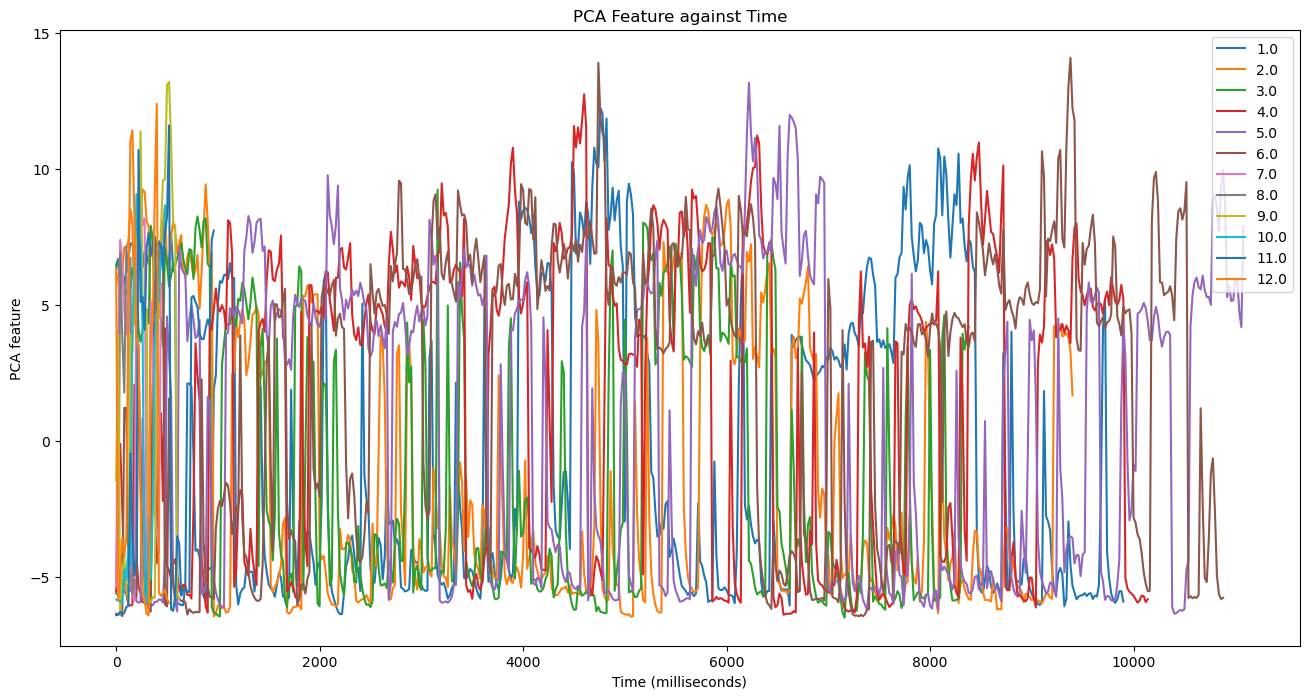

In [141]:
#### PLOTTING EACH DATAFRAME IN THE LIST 'entire_labels_partition_time' AS A LINE CHART ON THE SAME PLOT

# plotting the dataframes
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the dataframes
for partition in entire_labels_partition_time:
    ax.plot(partition['time'], partition['pca_feature_0'], label=partition['labels'][0])


# Add labels and title to the plot
plt.legend(loc='upper right')
plt.xlabel('Time (milliseconds)')
plt.ylabel('PCA feature')
plt.title('PCA Feature against Time')

# Show the plot
plt.show()

In [153]:
#### LINE PLOT TOO MESSY. MAKE IT INTERACTIVE

import plotly.graph_objs as go

# Create a plotly figure
int_fig = go.Figure()

# Add traces to the plotly figure
for i, partition in enumerate(entire_labels_partition_time):
    int_fig.add_trace(go.Scatter(x=partition['time'], y=partition['pca_feature_0'], mode='lines', name=f'Line {i+1}'))

# Update layout of the plotly figure
int_fig.update_layout(title='Title of the plot',
                  xaxis_title='X-axis label',
                  yaxis_title='Y-axis label')

# Show the plotly figure
int_fig.show()